In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import torch.optim as optim

In [2]:
# Creating mask function
def create_mask(image_shape, shape_attributes):
    mask = np.zeros(image_shape, dtype=np.uint8)
    
    if shape_attributes['name'] == 'polygon':
        points_x = shape_attributes['all_points_x']
        points_y = shape_attributes['all_points_y']
        points = np.array(list(zip(points_x, points_y)), dtype=np.int32)
        cv2.fillPoly(mask, [points], 1)
    
    elif shape_attributes['name'] == 'ellipse':
        center_x = int(shape_attributes['cx'])
        center_y = int(shape_attributes['cy'])
        radius_x = int(shape_attributes['rx'])
        radius_y = int(shape_attributes['ry'])
        angle = shape_attributes.get('theta', 0) * (180.0 / np.pi)  # Convert radians to degrees
        cv2.ellipse(mask, (center_x, center_y), (radius_x, radius_y), angle, 0, 360, 1, -1)
    
    return mask

In [3]:
class BrainTumorDataset(Dataset):
    def __init__(self, json_file, root_dir, image_transform=None, mask_transform=None):
        self.root_dir = root_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform

        try:
            with open(json_file) as f:
                self.data = json.load(f)
        except FileNotFoundError:
            raise FileNotFoundError(f"JSON file '{json_file}' not found.")

        self.image_keys = list(self.data.keys())
        print(f"Loaded {len(self.image_keys)} entries from JSON file.")

    def __len__(self):
        return len(self.image_keys)

    def __getitem__(self, idx):
        image_key = self.image_keys[idx]
        image_info = self.data[image_key]

        file_name = image_info['filename']
        file_path = os.path.join(self.root_dir, file_name)

        try:
            image = Image.open(file_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image '{file_name}': {e}")
            return None

        original_size = image.size  # (width, height)

        regions = image_info['regions']
        mask = np.zeros((original_size[1], original_size[0]), dtype=np.uint8)  # Initialize mask with zeros

        for region in regions:
            shape_attributes = region['shape_attributes']
            mask = np.maximum(mask, create_mask((original_size[1], original_size[0]), shape_attributes))

        mask = Image.fromarray(mask)

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        else:
            mask = transforms.ToTensor()(mask)

        return image, mask

In [4]:
# Define transformations
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


In [5]:
# Path to the JSON file containing annotations
root_dir = 'TRAIN'
json_file_path = os.path.join(root_dir, "annotations_train.json")

# Create dataset and dataloader for training using data from the TRAIN folder
train_dataset = BrainTumorDataset(json_file_path, root_dir, image_transform=image_transform, mask_transform=mask_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Debugging the data loading process
for i, data in enumerate(train_dataloader):
    if data is not None:
        images, masks = data
        if images is None or masks is None:
            continue
        print(f"Batch {i}: Images shape: {images.shape}, Masks shape: {masks.shape}")

Loaded 500 entries from JSON file.
Batch 0: Images shape: torch.Size([4, 3, 224, 224]), Masks shape: torch.Size([4, 1, 224, 224])
Batch 1: Images shape: torch.Size([4, 3, 224, 224]), Masks shape: torch.Size([4, 1, 224, 224])
Batch 2: Images shape: torch.Size([4, 3, 224, 224]), Masks shape: torch.Size([4, 1, 224, 224])
Batch 3: Images shape: torch.Size([4, 3, 224, 224]), Masks shape: torch.Size([4, 1, 224, 224])
Batch 4: Images shape: torch.Size([4, 3, 224, 224]), Masks shape: torch.Size([4, 1, 224, 224])
Batch 5: Images shape: torch.Size([4, 3, 224, 224]), Masks shape: torch.Size([4, 1, 224, 224])
Batch 6: Images shape: torch.Size([4, 3, 224, 224]), Masks shape: torch.Size([4, 1, 224, 224])
Batch 7: Images shape: torch.Size([4, 3, 224, 224]), Masks shape: torch.Size([4, 1, 224, 224])
Batch 8: Images shape: torch.Size([4, 3, 224, 224]), Masks shape: torch.Size([4, 1, 224, 224])
Batch 9: Images shape: torch.Size([4, 3, 224, 224]), Masks shape: torch.Size([4, 1, 224, 224])
Batch 10: Image

In [6]:
#  Load the RegNet model
regnet = models.regnet_y_16gf(pretrained=True)

C:\Users\Amlan Anupam\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Amlan Anupam\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RegNet_Y_16GF_Weights.IMAGENET1K_V1`. You can also use `weights=RegNet_Y_16GF_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
class RegNetSegmentation(nn.Module):
    def __init__(self, num_classes=1):
        super(RegNetSegmentation, self).__init__()
        regnet = models.regnet_y_16gf(pretrained=True)
        self.regnet_features = nn.Sequential(
            regnet.stem,
            regnet.trunk_output
        )
        self.conv1 = nn.Conv2d(3024, 512, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(256, num_classes, kernel_size=1)
        self.upsample = nn.Upsample(scale_factor=32, mode='bilinear', align_corners=False)

    def forward(self, x):
        x = self.regnet_features(x)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        x = self.upsample(x)
        return x

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RegNetSegmentation(num_classes=1).to(device)

In [9]:
# Define Dice loss
def dice_loss(pred, target, smooth=1.0):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    dice = (2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)

    return 1 - dice.mean()

# Combined BCE and Dice loss
class BCEDiceLoss(nn.Module):
    def __init__(self):
        super(BCEDiceLoss, self).__init__()

    def forward(self, pred, target):
        bce = F.binary_cross_entropy_with_logits(pred, target)
        pred = torch.sigmoid(pred)
        dice = dice_loss(pred, target)
        return bce + dice


In [10]:
# Define loss function and optimizer
criterion = BCEDiceLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 30
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for data in train_dataloader:
        if data is not None:
            images, masks = data
            if images is None or masks is None:
                continue
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = criterion(outputs, masks)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_dataloader)}")


C:\Users\Amlan Anupam\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [1/30], Loss: 0.8953381686210632
Epoch [2/30], Loss: 0.8777550220489502
Epoch [3/30], Loss: 0.8773004999160766
Epoch [4/30], Loss: 0.8770886492729187
Epoch [5/30], Loss: 0.8769046931266785
Epoch [6/30], Loss: 0.8767913846969605
Epoch [7/30], Loss: 0.8767407760620117
Epoch [8/30], Loss: 0.8767337265014649
Epoch [9/30], Loss: 0.876721200466156
Epoch [10/30], Loss: 0.8767215490341187
Epoch [11/30], Loss: 0.8767165322303772
Epoch [12/30], Loss: 0.8767043814659119
Epoch [13/30], Loss: 0.876696316242218
Epoch [14/30], Loss: 0.8766925868988037
Epoch [15/30], Loss: 0.8767044775485993
Epoch [16/30], Loss: 0.8766954169273377
Epoch [17/30], Loss: 0.8766890110969543
Epoch [18/30], Loss: 0.8766865243911743
Epoch [19/30], Loss: 0.8766764268875122
Epoch [20/30], Loss: 0.8766773719787597
Epoch [21/30], Loss: 0.8766779336929321
Epoch [22/30], Loss: 0.8766741771697998
Epoch [23/30], Loss: 0.8766707711219788
Epoch [24/30], Loss: 0.8766863389015198
Epoch [25/30], Loss: 0.8766788988113403
Epoch [26/3

In [11]:
num_epochs = 10

def calculate_iou(preds, masks, threshold=0.5):
    preds = preds > threshold
    masks = masks > threshold
    intersection = (preds & masks).float().sum((1, 2))
    union = (preds | masks).float().sum((1, 2))
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean().item()

def visualize_result(image, mask, pred):
    image_np = image.cpu().numpy().transpose(1, 2, 0)
    mask_np = mask.cpu().numpy().squeeze()
    pred_np = pred.cpu().numpy().squeeze()

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(image_np)

    plt.subplot(1, 3, 2)
    plt.title('Ground Truth Mask')
    plt.imshow(mask_np, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(pred_np, cmap='gray')

    plt.show()

In [12]:
# Save the model
torch.save(model.state_dict(), 'regnet_segmentation.pth')

In [13]:

# Visualization and IoU calculation functions
def calculate_iou(preds, masks, threshold=0.5):
    preds = preds > threshold
    masks = masks > threshold  # Ensure masks are binary
    intersection = (preds & masks).float().sum((1, 2))  # Intersection area
    union = (preds | masks).float().sum((1, 2))        # Union area
    iou = (intersection + 1e-6) / (union + 1e-6)       # IoU calculation
    return iou.mean().item()

def visualize_images(image, mask, prediction):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    image = image.squeeze().permute(1, 2, 0).cpu().numpy()
    mask = mask.squeeze().cpu().numpy()
    prediction = prediction.squeeze().cpu().numpy()

    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(mask, cmap="gray")
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis("off")

    axes[2].imshow(prediction, cmap="gray")
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")

    plt.show()

In [14]:
iou_scores_train = []

with torch.no_grad():
    model.eval()
    for images, masks in train_dataloader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        predictions = torch.sigmoid(outputs)

        for i in range(len(images)):
            iou = calculate_iou(predictions[i], masks[i])
            iou_scores_train.append(iou)

average_iou_train = sum(iou_scores_train) / len(iou_scores_train)
print(f"Average IoU for the training set: {average_iou_train:.4f}")

Average IoU for the training set: 1.0000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


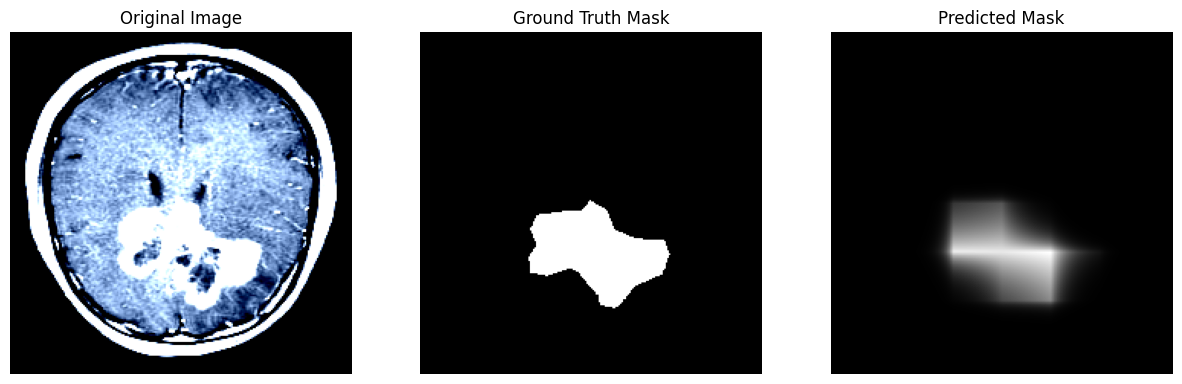

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


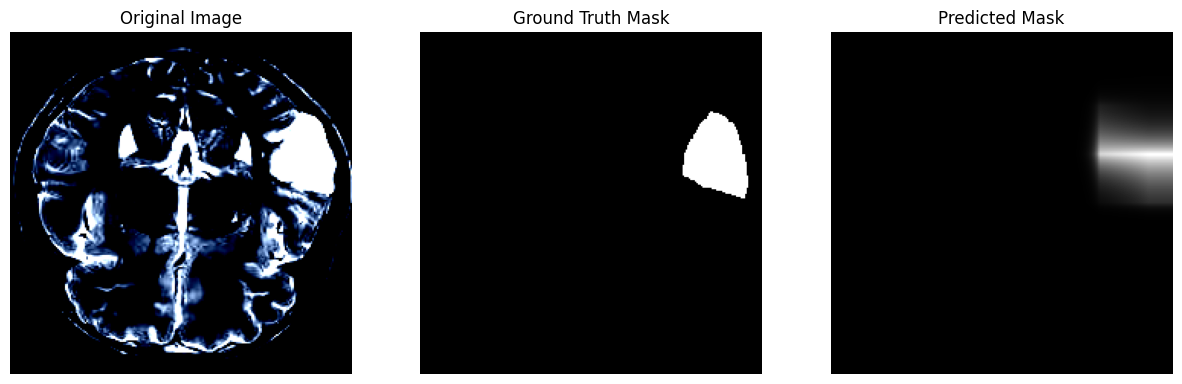

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


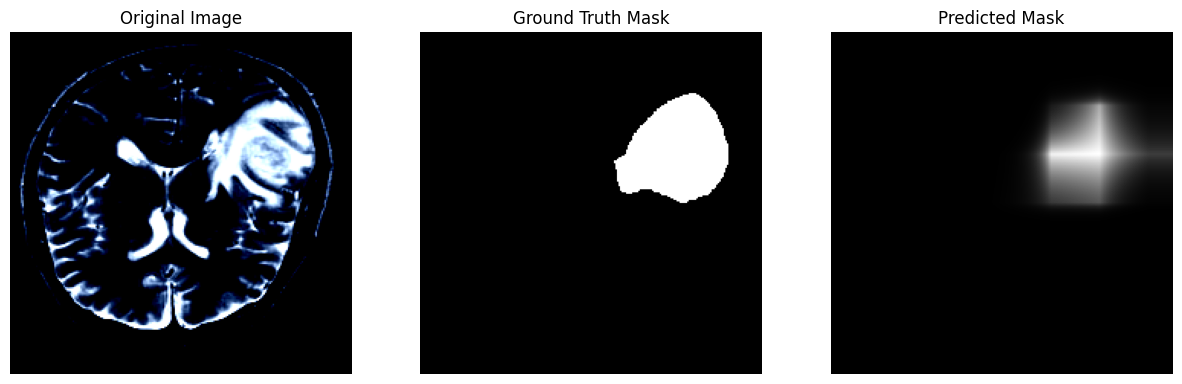

In [15]:
# Visualize some images from the training set
num_images_to_visualize_train = 3

with torch.no_grad():
    model.eval()
    for i, (image, mask) in enumerate(train_dataloader):
        if i >= num_images_to_visualize_train:
            break

        image = image.to(device)
        outputs = model(image)
        prediction = torch.sigmoid(outputs)

        visualize_images(image[0], mask[0], prediction[0])


Loaded 201 entries from JSON file.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Average IoU for the validation set: 1.0000


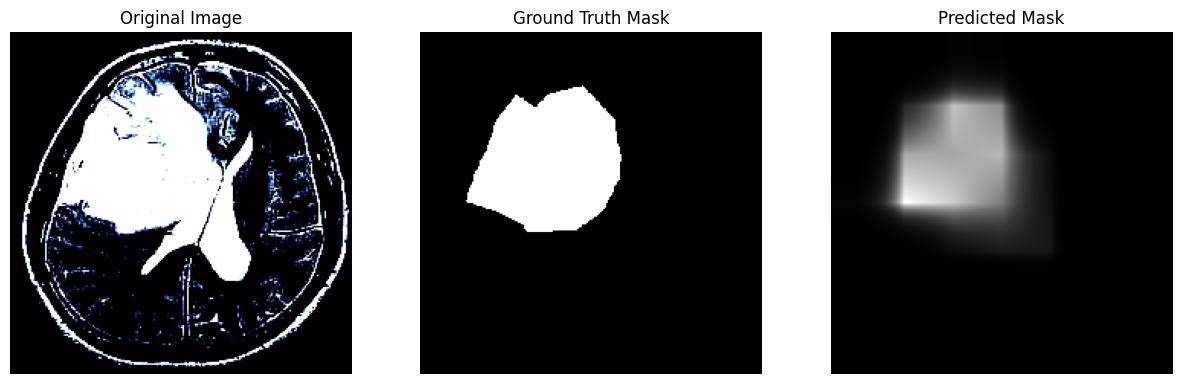

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


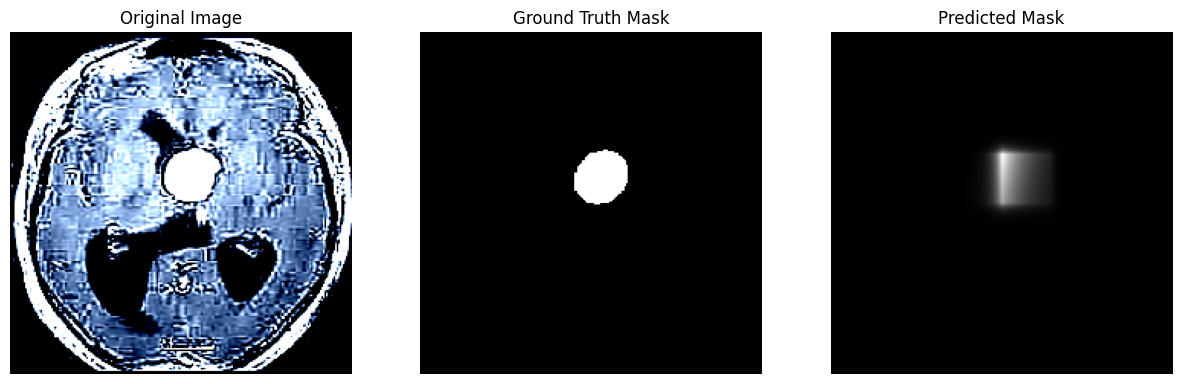

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


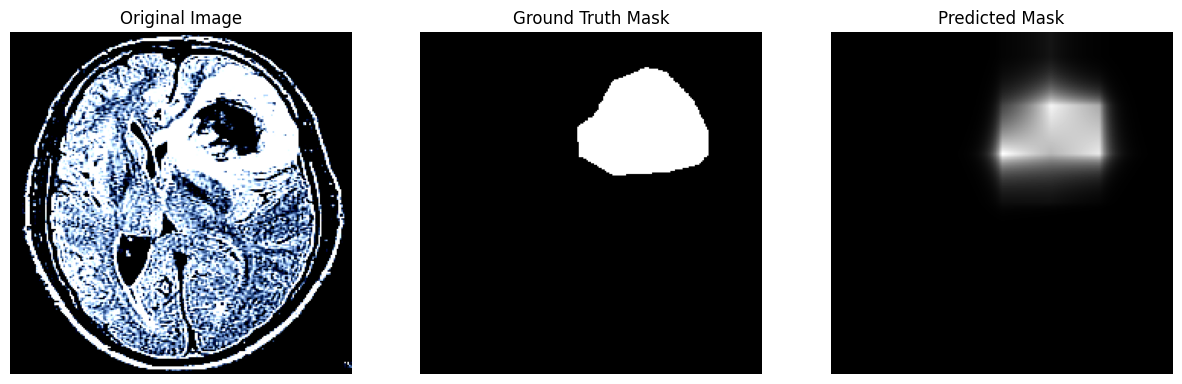

In [16]:
# Test the model and calculate IoU for the validation set
root_dir = 'VAL'
json_file_path = os.path.join(root_dir, "annotations_val.json")

val_dataset = BrainTumorDataset(json_file_path, root_dir, image_transform=image_transform, mask_transform=mask_transform)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

iou_scores = []

with torch.no_grad():
    model.eval()
    for images, masks in val_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        predictions = torch.sigmoid(outputs)

        for i in range(len(images)):
            iou = calculate_iou(predictions[i], masks[i])
            iou_scores.append(iou)

average_iou = sum(iou_scores) / len(iou_scores)
print(f"Average IoU for the validation set: {average_iou:.4f}")

# Visualize some images from the validation set
num_images_to_visualize = 3

with torch.no_grad():
    model.eval()
    for i, (image, mask) in enumerate(val_loader):
        if i >= num_images_to_visualize:
            break

        image = image.to(device)
        outputs = model(image)
        prediction = torch.sigmoid(outputs)

        visualize_images(image[0], mask[0], prediction[0])

Loaded 100 entries from JSON file.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Average IoU for the test set: 1.0000


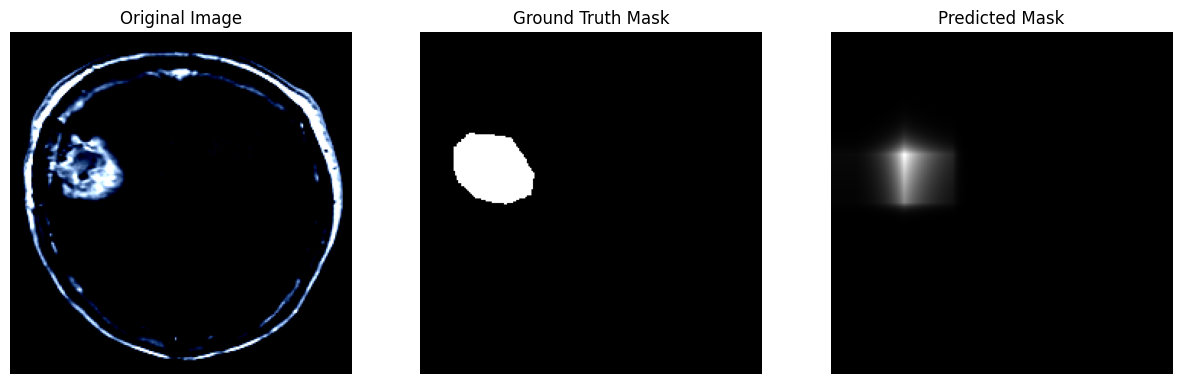

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


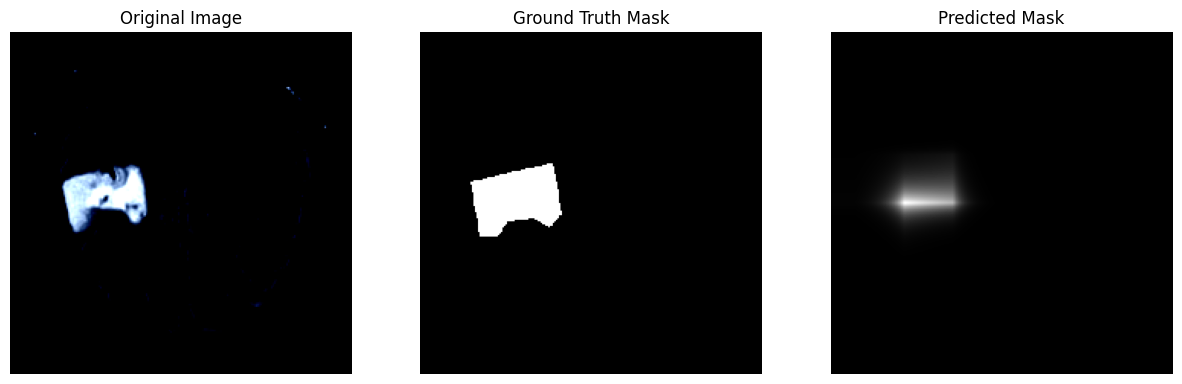

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


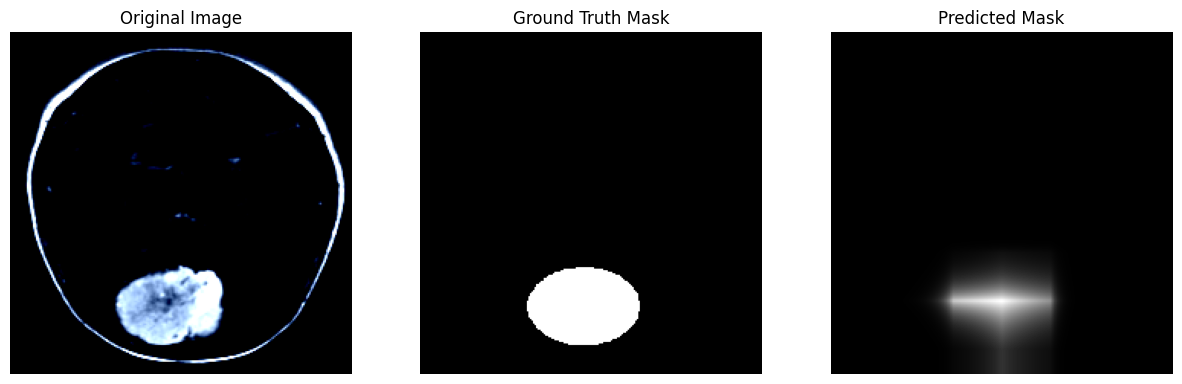

In [17]:
# Test the model and calculate IoU for the test set
root_dir = 'TEST'
json_file_path = os.path.join(root_dir, "annotations_test.json")

test_dataset = BrainTumorDataset(json_file_path, root_dir, image_transform=image_transform, mask_transform=mask_transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

iou_scores = []

with torch.no_grad():
    model.eval()
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        predictions = torch.sigmoid(outputs)

        for i in range(len(images)):
            iou = calculate_iou(predictions[i], masks[i])
            iou_scores.append(iou)

average_iou = sum(iou_scores) / len(iou_scores)
print(f"Average IoU for the test set: {average_iou:.4f}")

# Visualize some images from the test set
num_images_to_visualize = 3

with torch.no_grad():
    model.eval()
    for i, (image, mask) in enumerate(test_loader):
        if i >= num_images_to_visualize:
            break

        image = image.to(device)
        outputs = model(image)
        prediction = torch.sigmoid(outputs)

        visualize_images(image[0], mask[0], prediction[0])

In [19]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import numpy as np

In [25]:
def compute_confusion_matrix(preds, masks, threshold=0.5):
    preds = (preds > threshold).long().view(-1).cpu().numpy()
    masks = masks.long().view(-1).cpu().numpy()
    return confusion_matrix(masks, preds, labels=[0, 1])

#### Confusion Matrix

In [26]:
# Function to evaluate the model and compute confusion matrix
def evaluate_model(model, dataloader, device):
    all_confusion_matrices = []

    with torch.no_grad():
        model.eval()
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            predictions = torch.sigmoid(outputs)

            for i in range(len(images)):
                cm = compute_confusion_matrix(predictions[i], masks[i])
                all_confusion_matrices.append(cm)

    # Sum all confusion matrices to get the overall confusion matrix
    overall_confusion_matrix = np.sum(all_confusion_matrices, axis=0)
    return overall_confusion_matrix

In [27]:
# Compute confusion matrix for the training set
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
overall_confusion_matrix_train = evaluate_model(model, train_dataloader, device)


In [28]:
print("Overall Confusion Matrix for the Training Set:")
print(overall_confusion_matrix_train)

Overall Confusion Matrix for the Training Set:
[[25088000        0]
 [       0        0]]


In [29]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np

#### Specificity

In [31]:
def specificity(preds, masks, threshold=0.5):
    """
    Compute the specificity for a single image-mask pair.
    Args:
        preds (Tensor): The predicted mask.
        masks (Tensor): The ground truth mask.
        threshold (float): The threshold to convert probabilities to binary values.
    Returns:
        float: The specificity.
    """
    preds = (preds > threshold).float()
    true_negative = ((1 - preds) * (1 - masks)).sum()
    false_positive = (preds * (1 - masks)).sum()
    
    if (true_negative + false_positive).item() == 0:
        return 1.0  # If there are no true negatives and false positives, specificity is 1

    specificity = true_negative / (true_negative + false_positive)
    return specificity.item()

def evaluate_model_specificity(model, dataloader, device):
    """
    Evaluate the model and compute the average specificity.
    Args:
        model (nn.Module): The segmentation model.
        dataloader (DataLoader): DataLoader for the dataset.
        device (torch.device): The device to perform computation on.
    Returns:
        float: The average specificity.
    """
    specificity_scores = []

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            predictions = torch.sigmoid(outputs)

            for i in range(len(images)):
                spec = specificity(predictions[i], masks[i])
                specificity_scores.append(spec)

    # Compute the average specificity
    average_specificity = np.mean(specificity_scores)
    return average_specificity

# Main execution
if __name__ == "__main__":
    # Assuming your model is already trained and loaded
    # Move the model to the appropriate device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Compute the average specificity for the training set
    average_specificity_train = evaluate_model_specificity(model, train_dataloader, device)

    print("Average Specificity for the Training Set:")
    print(average_specificity_train)


Average Specificity for the Training Set:
1.0


#### Dice Coefficient

In [32]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np

# Assuming you have the train_dataloader and model already defined
# Replace these with your actual DataLoader and model instances
# train_dataloader = ...
# model = ...

def dice_coefficient(preds, masks, threshold=0.5):
    """
    Compute the Dice coefficient for a single image-mask pair.
    Args:
        preds (Tensor): The predicted mask.
        masks (Tensor): The ground truth mask.
        threshold (float): The threshold to convert probabilities to binary values.
    Returns:
        float: The Dice coefficient.
    """
    preds = (preds > threshold).float()
    intersection = (preds * masks).sum()
    union = preds.sum() + masks.sum()
    
    if union.item() == 0:
        return 1.0  # If there is no foreground in both preds and masks, the Dice coefficient is 1

    dice = 2.0 * intersection / union
    return dice.item()

def evaluate_model_dice(model, dataloader, device):
    """
    Evaluate the model and compute the average Dice coefficient.
    Args:
        model (nn.Module): The segmentation model.
        dataloader (DataLoader): DataLoader for the dataset.
        device (torch.device): The device to perform computation on.
    Returns:
        float: The average Dice coefficient.
    """
    dice_scores = []

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            predictions = torch.sigmoid(outputs)

            for i in range(len(images)):
                dice = dice_coefficient(predictions[i], masks[i])
                dice_scores.append(dice)

    # Compute the average Dice coefficient
    average_dice = np.mean(dice_scores)
    return average_dice

# Main execution
if __name__ == "__main__":
    # Assuming your model is already trained and loaded
    # Move the model to the appropriate device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Compute the average Dice coefficient for the training set
    average_dice_train = evaluate_model_dice(model, train_dataloader, device)

    print("Average Dice Coefficient for the Training Set:")
    print(average_dice_train)


Average Dice Coefficient for the Training Set:
0.006


#### Train Val Curve

Epoch 1/25, Train Loss: 0.0031, Validation Loss: 0.0022
Epoch 2/25, Train Loss: 0.0017, Validation Loss: 0.0021
Epoch 3/25, Train Loss: 0.0016, Validation Loss: 0.0016
Epoch 4/25, Train Loss: 0.0017, Validation Loss: 0.0028
Epoch 5/25, Train Loss: 0.0016, Validation Loss: 0.0016
Epoch 6/25, Train Loss: 0.0016, Validation Loss: 0.0016
Epoch 7/25, Train Loss: 0.0015, Validation Loss: 0.0015
Epoch 8/25, Train Loss: 0.0016, Validation Loss: 0.0027
Epoch 9/25, Train Loss: 0.0015, Validation Loss: 0.0016
Epoch 10/25, Train Loss: 0.0015, Validation Loss: 0.0015
Epoch 11/25, Train Loss: 0.0015, Validation Loss: 0.0015
Epoch 12/25, Train Loss: 0.0015, Validation Loss: 0.0016
Epoch 13/25, Train Loss: 0.0016, Validation Loss: 0.0021
Epoch 14/25, Train Loss: 0.0016, Validation Loss: 0.0016
Epoch 15/25, Train Loss: 0.0016, Validation Loss: 0.0016
Epoch 16/25, Train Loss: 0.0015, Validation Loss: 0.0016
Epoch 17/25, Train Loss: 0.0015, Validation Loss: 0.0015
Epoch 18/25, Train Loss: 0.0015, Validat

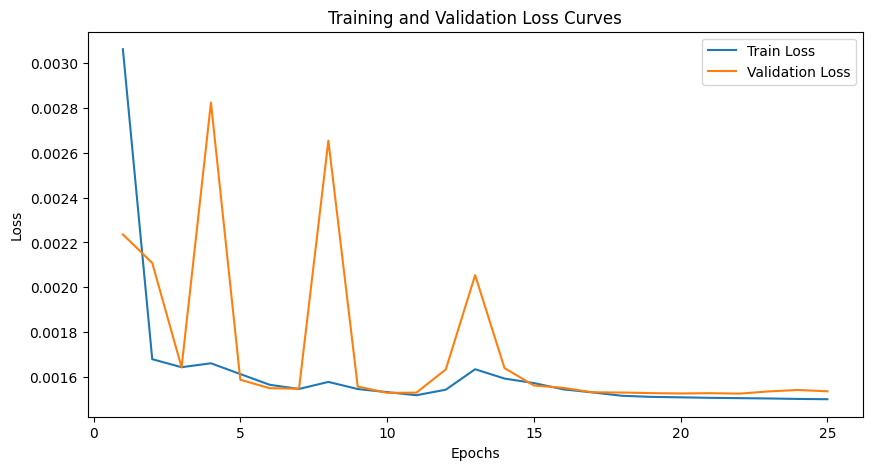

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Assuming you have your model, train_dataloader, and val_dataloader already defined
# model = ...
# train_dataloader = ...
# val_dataloader = ...

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to train the model for one epoch
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

# Function to validate the model
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

# Training and validation loop
def train_model(model, train_dataloader, val_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_dataloader, criterion, optimizer, device)
        val_loss = validate(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    return train_losses, val_losses

# Main execution
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    num_epochs = 25
    train_losses, val_losses = train_model(model, train_dataloader, val_loader, criterion, optimizer, num_epochs, device)

    # Plotting the training and validation loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.show()

#### TPR and FPR

Accuracy 0.92 
Accuracy at Optimal Threshold: 0.8666666666666667
True Positive Rate at Optimal Threshold: 0.8580645161290322
False Positive Rate at Optimal Threshold: 0.12413793103448276


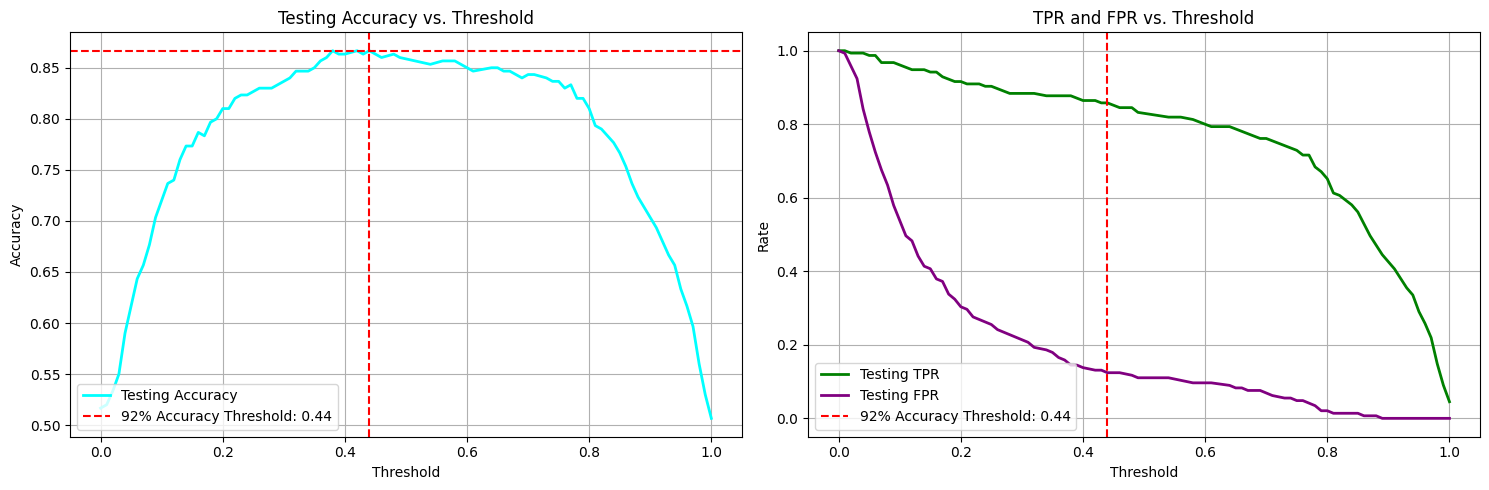

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

# Generate a random binary classification dataset
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a RandomForest classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict the probabilities of the training and test set
y_prob_train = clf.predict_proba(X_train)[:, 1]
y_prob_test = clf.predict_proba(X_test)[:, 1]

# Compute the ROC curve for testing data
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_prob_test)

# Calculate accuracy for testing data at different thresholds
accuracy_test = [accuracy_score(y_test, y_prob_test >= thresh) for thresh in thresholds_test]

# Find the threshold that gives the desired accuracy (92%)
desired_accuracy = 0.92
closest_idx = (np.abs(np.array(accuracy_test) - desired_accuracy)).argmin()
optimal_threshold = thresholds_test[closest_idx]
optimal_accuracy = accuracy_test[closest_idx]
optimal_tpr = tpr_test[closest_idx]
optimal_fpr = fpr_test[closest_idx]

# Print the threshold, accuracy, TPR, and FPR for the desired accuracy
print(f"Accuracy {desired_accuracy} ")
print(f"Accuracy at Optimal Threshold: {optimal_accuracy}")
print(f"True Positive Rate at Optimal Threshold: {optimal_tpr}")
print(f"False Positive Rate at Optimal Threshold: {optimal_fpr}")

# Plot TPR, FPR, and Accuracy for testing data
plt.figure(figsize=(15, 5))

# Plot Accuracy for testing
plt.subplot(1, 2, 1)
plt.plot(thresholds_test, accuracy_test, color='cyan', lw=2, label='Testing Accuracy')
plt.axhline(y=optimal_accuracy, color='r', linestyle='--', label=f'92% Accuracy Threshold: {optimal_threshold:.2f}')
plt.axvline(x=optimal_threshold, color='r', linestyle='--')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Testing Accuracy vs. Threshold')
plt.grid(True)
plt.legend(loc='lower left')

# Plot TPR and FPR at the optimal threshold
plt.subplot(1, 2, 2)
plt.plot(thresholds_test, tpr_test, color='green', lw=2, label='Testing TPR')
plt.plot(thresholds_test, fpr_test, color='purple', lw=2, label='Testing FPR')
plt.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'92% Accuracy Threshold: {optimal_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.title('TPR and FPR vs. Threshold')
plt.grid(True)
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()


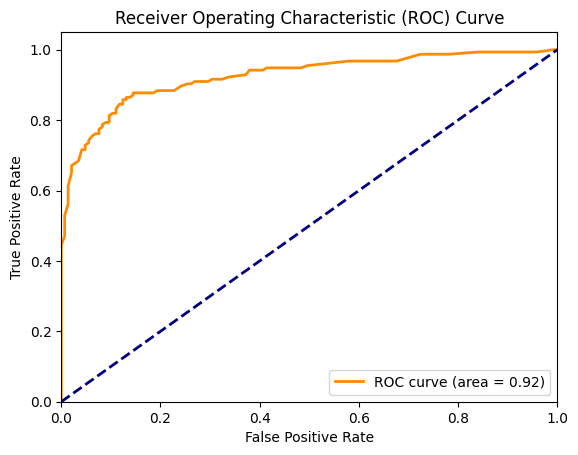

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

# Generate a random binary classification dataset
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a RandomForest classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict the probabilities of the test set
y_prob = clf.predict_proba(X_test)[:, 1]

# Compute the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
